<a href="https://colab.research.google.com/github/dklpp/tf-developer/blob/main/C3_W2_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Embedding - the vectors for each word, with their associated sentiment.

In [1]:
import tensorflow as tf

print(tf.__version__)

2.14.0


# Import IMDB data

In [2]:
import tensorflow_datasets as tfds

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJHPSZX/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJHPSZX/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJHPSZX/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
type(imdb)

dict

In [4]:
type(imdb['train'])

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [5]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

In [6]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s, l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all testing examples and save the sentences and labels
for s, l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

In [7]:
len(training_sentences)

25000

In [8]:
# Training process requirse np.array rather than list. Let's convert

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Tokenization

In [9]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences) # Fit tokenizer on train data

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)

padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [11]:
testing_padded.shape

(25000, 120)

In [12]:
padded.shape

(25000, 120)

In [13]:
testing_padded

array([[  11,  772, 1498, ...,   56,   46,  214],
       [  25, 5401,    3, ...,  962,    1,    1],
       [   2,  190,   13, ...,   18, 1163, 1017],
       ...,
       [   6,  104,   86, ...,   60,  514,  544],
       [   0,    0,    0, ...,   53,   71,  222],
       [   0,    0,    0, ...,  448, 8608, 2127]], dtype=int32)

# Neural Network Architecture

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), # averages across the vector to flatten it out (compare output shapes), makes faster training
    # but Flatten could be more accurate, even though it's a bit slower
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 160109 (625.43 KB)
Trainable params: 160109 (625.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

In [18]:
num_epochs = 10

model.fit(padded,
          training_labels_final,
          epochs=num_epochs,
          validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 41s 45ms/step - loss: 0.5530 - accuracy: 0.7535 - val_loss: 0.3856 - val_accuracy: 0.8420
Epoch 2/10
782/782 [==============================] - 9s 11ms/step - loss: 0.3316 - accuracy: 0.8632 - val_loss: 0.3292 - val_accuracy: 0.8598
Epoch 3/10
782/782 [==============================] - 7s 8ms/step - loss: 0.2692 - accuracy: 0.8924 - val_loss: 0.3336 - val_accuracy: 0.8560
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.2332 - accuracy: 0.9108 - val_loss: 0.3472 - val_accuracy: 0.8533
Epoch 5/10
782/782 [==============================] - 8s 10ms/step - loss: 0.2073 - accuracy: 0.9221 - val_loss: 0.3712 - val_accuracy: 0.8455
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.1862 - accuracy: 0.9324 - val_loss: 0.3944 - val_accuracy: 0.8401
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1688 - accuracy: 0.9412 - val_loss: 0.4170 - val_accuracy: 0.8381
Ep

- training accuracy: 0.95
- val accuracy: 0.82
- Probably it's overfitting

In [21]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape) # shape: (vocab_size, embedding_dim)

# 16 dimensional array of embedding space

(10000, 16)


In [22]:
reverse_word_index = tokenizer.index_word

# Visualize Word Embedding Space

In [23]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [24]:
# # Import files utilities in Colab
# try:
#   from google.colab import files
# except ImportError:
#   pass

# # Download the files
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

- Go to http://projector.tensorflow.org and visualize.

# Sarcasm Dataset Classifier

In [25]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-11-22 16:01:41--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.207, 74.125.23.207, 74.125.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  6.29MB/s    in 0.9s    

2023-11-22 16:01:42 (6.29 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [26]:
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

# Hyperparameters

In [27]:
training_size = 20000 # 7000 for testing
vocab_size = 10000
max_length = 32
embedding_dim = 16

# Split the Dataset

In [28]:
training_sentences = sentences[0:training_size]
training_labels = labels[0:training_size]

testing_sentences = sentences[training_size:]
testing_labels = labels[training_size:]

# Preprocessing

In [29]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

# Neural Network Architecture

In [30]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [31]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Training the Model

In [33]:
num_epochs = 30

# Train the model
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 19s - loss: 0.5645 - accuracy: 0.7018 - val_loss: 0.3998 - val_accuracy: 0.8354 - 19s/epoch - 31ms/step
Epoch 2/30
625/625 - 4s - loss: 0.3136 - accuracy: 0.8744 - val_loss: 0.3431 - val_accuracy: 0.8548 - 4s/epoch - 6ms/step
Epoch 3/30
625/625 - 2s - loss: 0.2366 - accuracy: 0.9072 - val_loss: 0.3573 - val_accuracy: 0.8430 - 2s/epoch - 4ms/step
Epoch 4/30
625/625 - 2s - loss: 0.1903 - accuracy: 0.9262 - val_loss: 0.3593 - val_accuracy: 0.8538 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 4s - loss: 0.1575 - accuracy: 0.9406 - val_loss: 0.3897 - val_accuracy: 0.8480 - 4s/epoch - 6ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1342 - accuracy: 0.9523 - val_loss: 0.4175 - val_accuracy: 0.8465 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1145 - accuracy: 0.9599 - val_loss: 0.4598 - val_accuracy: 0.8399 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.0981 - accuracy: 0.9667 - val_loss: 0.5034 - val_accuracy: 0.8387 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 

# Visualize the Results

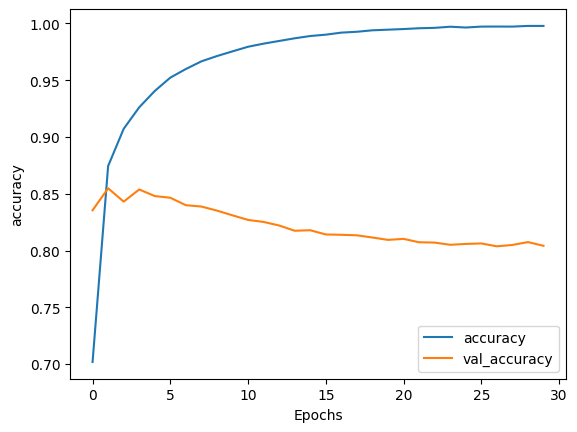

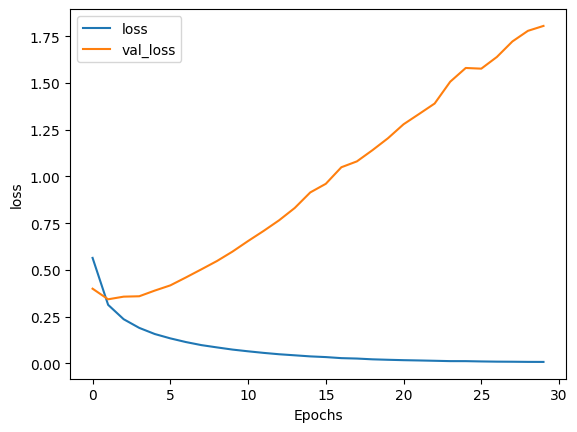

In [34]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# loss - "our confidence in prediction"

# Tweak the Hyperparameters

In [39]:
vocab_size = 1000 # was 10,000 (less vocabulary)
emedding_dim = 16
max_length = 16 # was 32 (take shorter sentences, reducec the likelihood of padding)
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
trainings_size = 20000

Epoch 1/30
625/625 - 14s - loss: 0.5266 - accuracy: 0.7318 - val_loss: 0.4109 - val_accuracy: 0.8140 - 14s/epoch - 23ms/step
Epoch 2/30
625/625 - 2s - loss: 0.3791 - accuracy: 0.8307 - val_loss: 0.3984 - val_accuracy: 0.8162 - 2s/epoch - 4ms/step
Epoch 3/30
625/625 - 2s - loss: 0.3634 - accuracy: 0.8352 - val_loss: 0.4045 - val_accuracy: 0.8161 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 2s - loss: 0.3576 - accuracy: 0.8376 - val_loss: 0.4051 - val_accuracy: 0.8134 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 3s - loss: 0.3554 - accuracy: 0.8395 - val_loss: 0.4065 - val_accuracy: 0.8109 - 3s/epoch - 5ms/step
Epoch 6/30
625/625 - 3s - loss: 0.3537 - accuracy: 0.8397 - val_loss: 0.4030 - val_accuracy: 0.8116 - 3s/epoch - 4ms/step
Epoch 7/30
625/625 - 2s - loss: 0.3523 - accuracy: 0.8389 - val_loss: 0.4027 - val_accuracy: 0.8143 - 2s/epoch - 4ms/step
Epoch 8/30
625/625 - 3s - loss: 0.3501 - accuracy: 0.8399 - val_loss: 0.4036 - val_accuracy: 0.8120 - 3s/epoch - 4ms/step
Epoch 9/30
625/625 - 

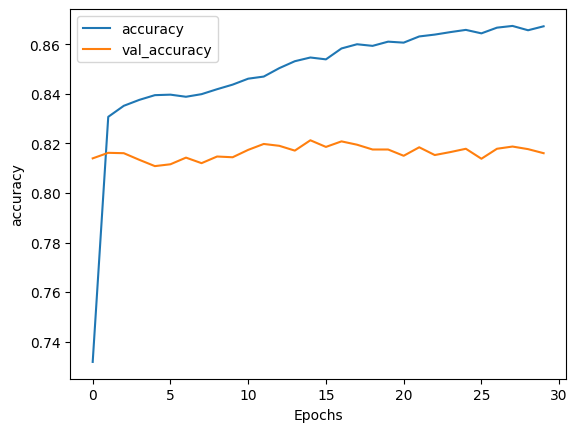

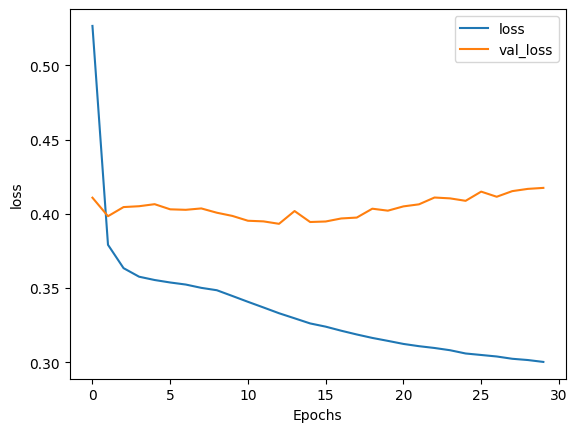

In [42]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 30

# Train the model
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=2)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

- Now the val loss is better, than it was.

In [43]:
vocab_size = 1000 # was 10,000 (less vocabulary)
emedding_dim = 32 # was 16
max_length = 16 # was 32 (take shorter sentences, reducec the likelihood of padding)
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
trainings_size = 20000

Epoch 1/30
625/625 - 14s - loss: 0.5266 - accuracy: 0.7308 - val_loss: 0.4099 - val_accuracy: 0.8126 - 14s/epoch - 22ms/step
Epoch 2/30
625/625 - 4s - loss: 0.3786 - accuracy: 0.8292 - val_loss: 0.3991 - val_accuracy: 0.8107 - 4s/epoch - 6ms/step
Epoch 3/30
625/625 - 3s - loss: 0.3629 - accuracy: 0.8352 - val_loss: 0.4056 - val_accuracy: 0.8159 - 3s/epoch - 4ms/step
Epoch 4/30
625/625 - 2s - loss: 0.3577 - accuracy: 0.8377 - val_loss: 0.4021 - val_accuracy: 0.8122 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 3s - loss: 0.3553 - accuracy: 0.8385 - val_loss: 0.4046 - val_accuracy: 0.8119 - 3s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.3547 - accuracy: 0.8383 - val_loss: 0.4050 - val_accuracy: 0.8123 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 3s - loss: 0.3526 - accuracy: 0.8386 - val_loss: 0.4076 - val_accuracy: 0.8085 - 3s/epoch - 4ms/step
Epoch 8/30
625/625 - 3s - loss: 0.3518 - accuracy: 0.8401 - val_loss: 0.4078 - val_accuracy: 0.8104 - 3s/epoch - 5ms/step
Epoch 9/30
625/625 - 

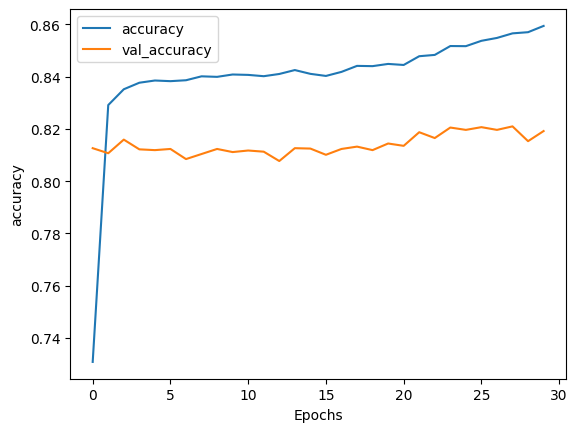

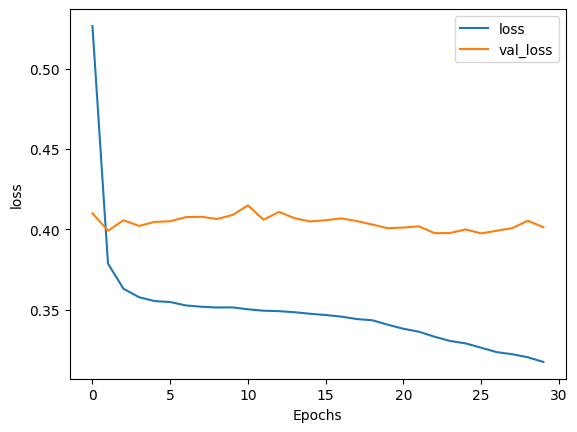

In [44]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 30

# Train the model
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=2)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Visualize Word Embeddings

In [35]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(10000, 16)


In [36]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [37]:
# # Import files utilities in Colab
# try:
#   from google.colab import files
# except ImportError:
#   pass

# # Download the files
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

# Subword Tokenization with the IMDB Reviews Dataset
- pre-tokenized dataset that is using subword text encoding. This is an alternative to word-based tokenization which you have been using in the previous labs. You will see how it works and its implications on preparing your data and training your model.
- plain_text - this is the default and the one you used in Lab 1 of this week
- subwords8k - a pre-tokenized dataset (i.e. instead of sentences of type string, it will already give you the tokenized sequences). You will see how this looks in later sections.



In [2]:
import tensorflow_datasets as tfds

# Download the plain text default config
imdb_plaintext, info_plaintext = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Download the subword encoded pretokenized dataset
imdb_subwords, info_subwords = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

## Compare the two datasets

- As mentioned, the data types returned by the two datasets will be different. For the default, it will be strings as you also saw in Lab 1. Notice the description of the text key below and the sample sentences:

In [3]:
# Print description of features
info_plaintext.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(), dtype=string),
})

In [4]:
# Take 2 training examples and print the text feature
for example in imdb_plaintext['train'].take(2):
  print(example[0].numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was

For subwords8k, the dataset is already tokenized so the data type will be integers. Notice that the text features also include an encoder field and has a vocab_size of around 8k, hence the name.

In [5]:
# Print description of features
info_subwords.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

In [6]:
# Take 2 training examples and print its contents
for example in imdb_subwords['train'].take(2):
  print(example)

(<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
       5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
          3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
         79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
         33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
         27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
         19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
        102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
          3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
          2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
        102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
         27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
         12,  258, 2306,   13,   91,   29,  171,   52,  229,    2, 1245,
    

- You can get the encoder object included in the download and use it to decode the sequences above. You'll see that you will arrive at the same sentences provided in the plain_text config:

In [7]:
# Get the encoder
tokenizer_subwords = info_subwords.features['text'].encoder

# Take 2 training examples and decode the text feature
for example in imdb_subwords['train'].take(2):
  print(tokenizer_subwords.decode(example[0]))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was cons

## Subword Text Encoding



In [8]:
# Get the train set
train_data = imdb_plaintext['train']

# Initialize sentences list
training_sentences = []

# Loop over all training examples and save to the list
for s,_ in train_data:
  training_sentences.append(s.numpy().decode('utf8'))

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
oov_tok = '<OOV>'

# Initialize the Tokenizer class
tokenizer_plaintext = Tokenizer(num_words = 10000, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer_plaintext.fit_on_texts(training_sentences)

# Generate the training sequences
sequences = tokenizer_plaintext.texts_to_sequences(training_sentences)

In [10]:
# Decode the first sequence using the Tokenizer class
tokenizer_plaintext.sequences_to_texts(sequences[0:1])

["this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher <OOV> good name i could barely sit through it"]

- For binary classifiers, this might not have a big impact but you may have other applications that will benefit from avoiding OOV tokens when training the model (e.g. text generation). If you want the tokenizer above to not have OOVs, then the vocab_size will increase to more than 88k. This can slow down training and bloat the model size. The encoder also won't be robust when used on other datasets which may contain new words, thus resulting in OOVs again

In [11]:
# Total number of words in the word index dictionary
len(tokenizer_plaintext.word_index)

88583

- Subword text encoding gets around this problem by using parts of the word to compose whole words. This makes it more flexible when it encounters uncommon words. See how these subwords look like for this particular encoder:

In [12]:
# Print the subwords
print(tokenizer_subwords.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

- If you use it on the previous plain text sentence, you'll see that it won't have any OOVs even if it has a smaller vocab size (only 8k compared to 10k above):

In [13]:
# Encode the first plaintext sentence using the subword text encoder
tokenized_string = tokenizer_subwords.encode(training_sentences[0])
print(tokenized_string)

# Decode the sequence
original_string = tokenizer_subwords.decode(tokenized_string)

# Print the result
print (original_string)

[62, 18, 41, 604, 927, 65, 3, 644, 7968, 21, 35, 5096, 36, 11, 43, 2948, 5240, 102, 50, 681, 7862, 1244, 3, 3266, 29, 122, 640, 2, 26, 14, 279, 438, 35, 79, 349, 384, 11, 1991, 3, 492, 79, 122, 188, 117, 33, 4047, 4531, 14, 65, 7968, 8, 1819, 3947, 3, 62, 27, 9, 41, 577, 5044, 2629, 2552, 7193, 7961, 3642, 3, 19, 107, 3903, 225, 85, 198, 72, 1, 1512, 738, 2347, 102, 6245, 8, 85, 308, 79, 6936, 7961, 23, 4981, 8044, 3, 6429, 7961, 1141, 1335, 1848, 4848, 55, 3601, 4217, 8050, 2, 5, 59, 3831, 1484, 8040, 7974, 174, 5773, 22, 5240, 102, 18, 247, 26, 4, 3903, 1612, 3902, 291, 11, 4, 27, 13, 18, 4092, 4008, 7961, 6, 119, 213, 2774, 3, 12, 258, 2306, 13, 91, 29, 171, 52, 229, 2, 1245, 5790, 995, 7968, 8, 52, 2948, 5240, 8039, 7968, 8, 74, 1249, 3, 12, 117, 2438, 1369, 192, 39, 7975]
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not re

Subword encoding can even perform well on words that are not commonly found on movie reviews. See first the result when using the plain text tokenizer. As expected, it will show many OOVs:

In [14]:
# Define sample sentence
sample_string = 'TensorFlow, from basics to mastery'

# Encode using the plain text tokenizer
tokenized_string = tokenizer_plaintext.texts_to_sequences([sample_string])
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
original_string = tokenizer_plaintext.sequences_to_texts(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [[1, 37, 1, 6, 1]]
The original string: ['<OOV> from <OOV> to <OOV>']


Then compare to the subword text encoder:



In [15]:
# Encode using the subword text encoder
tokenized_string = tokenizer_subwords.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the results
original_string = tokenizer_subwords.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


As you may notice, the sentence is correctly decoded. The downside is the token sequence is much longer. Instead of only 5 when using word-encoding, you ended up with 11 tokens instead. The mapping for this sentence is shown below:

In [16]:
# Show token to subword mapping:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_subwords.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


#Training the model

- You will now train your model using this pre-tokenized dataset. Since these are already saved as sequences, you can jump straight to making uniform sized arrays for the train and test sets. These are also saved as tf.data.Dataset type so you can use the padded_batch() method to create batches and pad the arrays into a uniform size for training.

In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Get the train and test splits
train_data, test_data = imdb_subwords['train'], imdb_subwords['test'],

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

In [18]:
import tensorflow as tf

# Define dimensionality of the embedding
embedding_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer_subwords.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 524237 (2.00 MB)
Trainable params: 524237 (2.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
num_epochs = 10

# Set the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Start training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 70s 171ms/step - loss: 0.6845 - accuracy: 0.5794 - val_loss: 0.6509 - val_accuracy: 0.7199
Epoch 2/10
391/391 [==============================] - 44s 113ms/step - loss: 0.5488 - accuracy: 0.7893 - val_loss: 0.4675 - val_accuracy: 0.8290
Epoch 3/10
391/391 [==============================] - 32s 80ms/step - loss: 0.3912 - accuracy: 0.8636 - val_loss: 0.3736 - val_accuracy: 0.8627
Epoch 4/10
391/391 [==============================] - 23s 60ms/step - loss: 0.3124 - accuracy: 0.8900 - val_loss: 0.3375 - val_accuracy: 0.8705
Epoch 5/10
391/391 [==============================] - 16s 40ms/step - loss: 0.2718 - accuracy: 0.9030 - val_loss: 0.3260 - val_accuracy: 0.8688
Epoch 6/10
391/391 [==============================] - 15s 38ms/step - loss: 0.2447 - accuracy: 0.9131 - val_loss: 0.3198 - val_accuracy: 0.8704
Epoch 7/10
391/391 [==============================] - 15s 39ms/step - loss: 0.2233 - accuracy: 0.9195 - val_loss: 0.3170 - val_accurac

# Visualize the Results

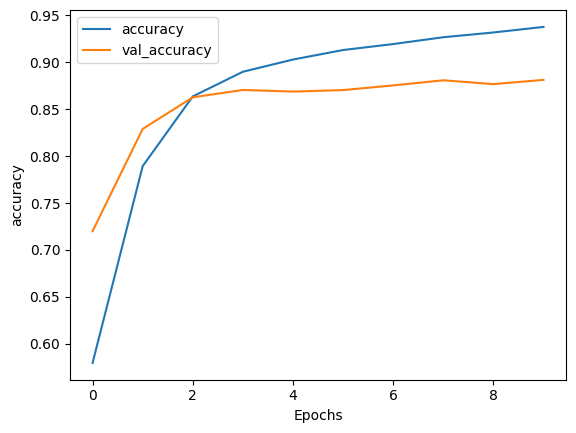

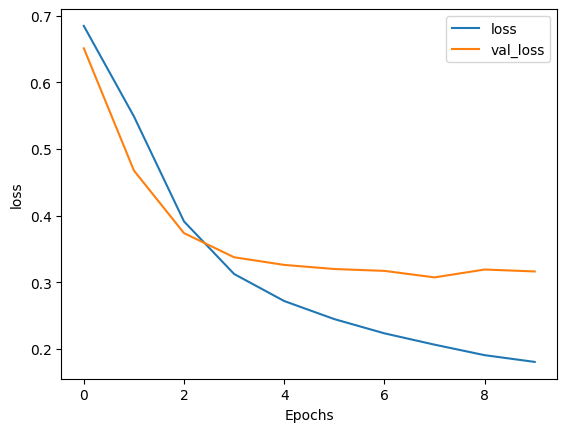

In [20]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")